In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

#set up
import torch, detectron2
print("detectron2:", detectron2.__version__)

from detectron2.utils.logger import setup_logger
setup_logger()

# import common libraries
import numpy as np
import os, json, cv2, random

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt

%matplotlib inline

/bin/bash: nvcc: command not found
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6
detectron2: 0.6


In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.data.datasets import  builtin_meta

In [4]:
register_coco_instances("guard_train", {}, "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg3/train/_annotations.coco.json", "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg3/train/")
register_coco_instances("guard_valid", {}, "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg3/valid/_annotations.coco.json", "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg3/valid/")

In [8]:
dataset_dicts = get_detection_dataset_dicts(["guard_train"])
_dataset_metadata = MetadataCatalog.get("guard_train")
_dataset_metadata.thing_colors = [cc['color'] for cc in builtin_meta.COCO_CATEGORIES]
NUM_CLASSES = len(_dataset_metadata.thing_classes)
print(f"{NUM_CLASSES} Number of classes in the dataset")

WARNING [11/20 19:02:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/20 19:02:39 d2.data.datasets.coco]: Loaded 18 images in COCO format from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg3/train/_annotations.coco.json
[11/20 19:02:39 d2.data.build]: Removed 0 images with no usable annotations. 18 images left.
2 Number of classes in the dataset


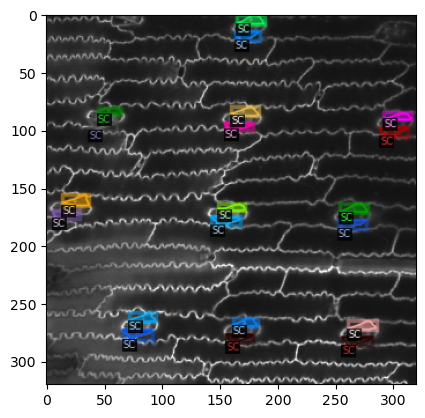

In [9]:
###check the dataset and annotation

for d in random.sample(dataset_dicts, 3):
    if '\\' in d['file_name']:
        d['file_name'] = d['file_name'].replace('\\','/')
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

In [9]:
### Train the model
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("guard_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 #@param
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =  2 #@param
cfg.SOLVER.BASE_LR = 0.00025 #@param # pick a good LR
cfg.SOLVER.MAX_ITER = 2000 #@param    # 300 iterations seems good enough for 100 frames dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 #@param   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  #  (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)



[11/20 19:03:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/lliu4_umass_edu/.conda/envs/GuardSeg/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/lliu4_umass_edu/.conda/envs/GuardSeg/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024)

In [23]:
# trainer.train()

[11/20 15:01:13 d2.engine.train_loop]: Starting training from iteration 0
[11/20 15:02:42 d2.utils.events]:  eta: 2:22:19  iter: 19  total_loss: 5.427  loss_cls: 1.153  loss_box_reg: 0.4128  loss_mask: 0.6934  loss_rpn_cls: 3.017  loss_rpn_loc: 0.1599    time: 4.3757  last_time: 3.1881  data_time: 0.0152  last_data_time: 0.0065   lr: 4.9953e-06  


2023-11-20 15:02:44.940805: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 15:02:46.141921: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 15:02:46.146902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 15:02:51.263285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[11/20 15:04:18 d2.utils.events]:  eta: 2:11:58  iter: 39  total_loss: 3.425  loss_cls: 1.014  loss_box_reg: 0.5648  loss_mask: 0.6918  loss_rpn_cls: 1.013  loss_rpn_loc: 0.131    time: 4.1589  last_time: 4.1521  data_time: 0.0046  last_data_time: 0.0039   lr: 9.9902e-06  
[11/20 15:06:00 d2.utils.events]:  eta: 2:11:55  iter: 59  total_loss: 2.503  loss_cls: 0.8979  loss_box_reg: 0.6278  loss_mask: 0.6878  loss_rpn_cls: 0.1526  loss_rpn_loc: 0.1137    time: 4.4841  last_time: 4.5489  data_time: 0.0043  last_data_time: 0.0066   lr: 1.4985e-05  
[11/20 15:07:17 d2.utils.events]:  eta: 2:08:12  iter: 79  total_loss: 2.391  loss_cls: 0.7909  loss_box_reg: 0.6754  loss_mask: 0.6818  loss_rpn_cls: 0.107  loss_rpn_loc: 0.1177    time: 4.3174  last_time: 3.1825  data_time: 0.0045  last_data_time: 0.0041   lr: 1.998e-05  
[11/20 15:08:43 d2.utils.events]:  eta: 2:06:21  iter: 99  total_loss: 2.269  loss_cls: 0.6986  loss_box_reg: 0.7009  loss_mask: 0.6736  loss_rpn_cls: 0.08188  loss_rpn_loc: 

In [22]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. 
# We simply update the weights with the newly trained ones to perform inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/output/model_final.pth")  # path to the model we just trained
# set a custom testing threshold

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1 #@param {type: "slider", min:0.0, max:1.0, step: 0.01}
predictor = DefaultPredictor(cfg)

[11/20 20:16:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/output/model_final.pth ...


In [23]:
from detectron2.utils.visualizer import ColorMode

WARNING [11/20 19:03:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/20 19:03:28 d2.data.datasets.coco]: Loaded 5 images in COCO format from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg3/valid/_annotations.coco.json
[11/20 19:03:28 d2.data.build]: Removed 0 images with no usable annotations. 5 images left.
[11/20 19:03:28 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   GC-SC    | 0            |     SC     | 121          |
|            |              |            |              |
|   total    | 121          |            |              |


/home/lliu4_umass_edu/.conda/envs/GuardSeg/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343899977/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


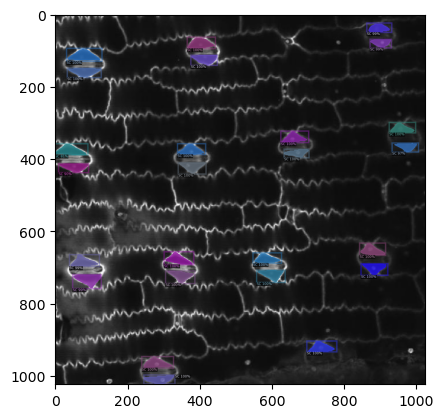

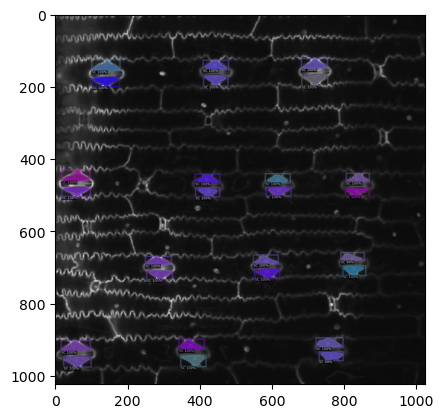

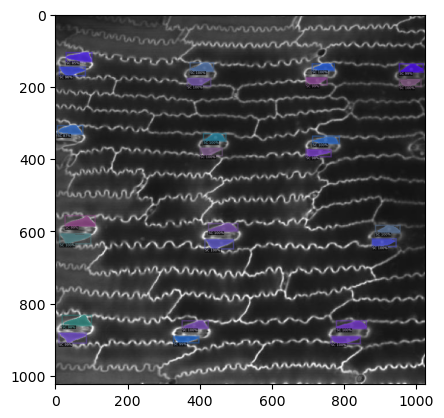

In [12]:
dataset_dicts = get_detection_dataset_dicts(["guard_valid"])
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=_dataset_metadata, 
                   scale=1.6, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
        

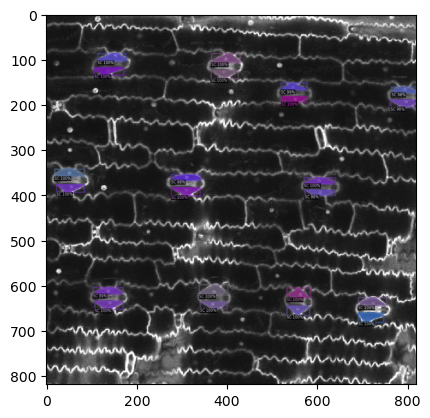

In [27]:
###Random select one image for detect
im = cv2.imread("NC358_1.png")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=_dataset_metadata, 
               scale=1.6, 
               instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()





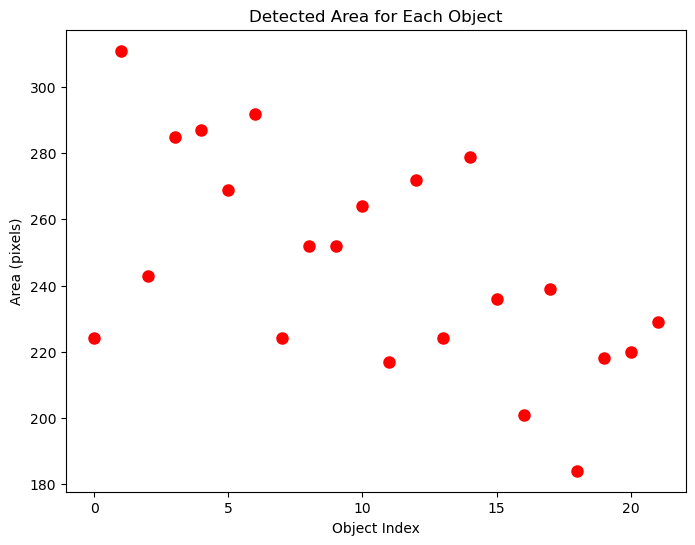

In [30]:
### Calculate the SC area:
# Initialize a list to store the areas
areas = []

# Calculate the detected area for each object
for mask in outputs["instances"].pred_masks:
    area = mask.sum()
    areas.append(area)

# Create a dot plot
plt.figure(figsize=(8, 6))
plt.plot(areas, 'ro', markersize=8)
plt.title('Detected Area for Each Object')
plt.xlabel('Object Index')
plt.ylabel('Area (pixels)')
plt.show()

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [15]:
evaluator = COCOEvaluator("guard_valid", cfg, False, output_dir="eval_output/")

val_loader = build_detection_test_loader(cfg, "guard_valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [11/20 19:03:47 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [11/20 19:03:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/20 19:03:47 d2.data.datasets.coco]: Loaded 5 images in COCO format from /work/pi_mfacette_umass_edu/lliu4_umass_edu-conda/envs/GuardSeg/detectron2/GuardSeg3/valid/_annotations.coco.json
[11/20 19:03:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/20 19:03:47 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/20 19:03:47 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[11/20 19:03:47 d2.data.common]: Serialized dataset takes 0.03 MiB
[11/20 19:03:47 d2.evaluation.evalu